In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import colors

In [2]:
pars={}
pars['N_episodes']=10000
pars['alpha'] = 0.1 #Step learning
pars['gamma'] = 0.9 #Discount factor
pars['eps'] = 0.1   #Epsilon greedy
pars['pd']= 0.6    #Probability to not decay
pars['growth_range']=5
pars['factor_range']=10
pars['ci_range']=np.arange(2,8)

pars['nstates']=(pars['growth_range']+1,pars['factor_range']+1,pars['factor_range']+1)

In [3]:
opt_range={}
#Germinazione 
opt_range[1]={'Tem':[[3,4,5],[2,6,7,8],[1,9],[0,10]],'Hum':[[6,7,8],[2,3,4,5],[1,9],[0,10]]}
#Crescita iniziale
opt_range[2]={'Tem':[[6,7,8],[4,5],[1,2,3,9],[0,10]],'Hum':[[4,5,6],[2,3,7,8],[1,9],[0,10]]}
#Crescita avanzanta
opt_range[3]={'Tem':[[5,6,7],[3,4,8],[1,2,9],[0,10]],'Hum':[[6,7,8],[3,4,5],[1,2,9],[0,10]]}
#Maturazione
opt_range[4]={'Tem':[[6,7,8],[4,5,9],[1,2,3],[0,10]],'Hum':[[7,8,9],[4,5,6],[1,2,3],[0,10]]}

pars['opt_range']=opt_range

In [4]:
# opt_range = {}
# #Germinazione 
# opt_range[1] = {'Tem': [[4,5,6], [2, 3, 7], [1,8,9], [0, 10]], 'Hum': [[6, 7, 8], [4, 5,9], [1,2,3], [0,10]]}
# #Crescita iniziale
# opt_range[2] = {'Tem': [[6, 7, 8], [4, 5,9], [1,2,3], [0,10]], 'Hum': [[4,5,6], [2,3, 7], [1,8,9], [0, 10]]}
# #Crescita avanzanta
# opt_range[3] = {'Tem': [[6, 7,8], [4, 5, 9], [1, 2, 3], [0,10]], 'Hum': [[5,6, 7], [3, 4, 8], [1, 2, 9], [0, 10]]}
# #Maturazione
# opt_range[4] = {'Tem': [[4, 5, 6], [2, 3, 7, 8], [1, 9], [0, 10]], 'Hum': [[5,6,7], [3,4,8], [1, 2, 9], [0, 10]]}
# 
# pars['opt_range'] = opt_range

In [5]:
def growth_state(growth,temp,hum,range_tem,range_hum):
    #At least one red: bad condition to growth -2
    if temp in range_tem[3] or hum in range_hum[3]:
      growth+=-2
      growth=max(growth,0)
    #At least one orange : poor condition to growth -1
    elif temp in range_tem[2] or hum in range_hum[2]:
      growth+=-1
      growth=max(growth,0)
    #At least one yellow : good condition to growth +0
    elif temp in range_tem[1] or hum in range_hum[1]:
     growth+=0
    else:
     #Only green : Optimal condition to growth +1
     growth+=1
     growth=min(growth,5)
        
    return growth

In [6]:
def next_state(state,action,pars):
    growth,temp,hum = state
    
    prev_growth=growth
       
    range_tem,range_hum=pars['opt_range'].get(growth)['Tem'],pars['opt_range'].get(growth)['Hum']
    
    #Probability not to decay
    if action == 0:
        w=np.random.choice([-1,0],p=[1-pars['pd'],pars['pd']])
        temp+=w
        hum+=w
    if action == 1:
       temp+=1
       temp=min(temp,pars['factor_range'])
    if action == 2:
       hum+=1
       hum=min(hum,pars['factor_range'])
    
    growth=growth_state(growth,temp,hum,range_tem,range_hum)  
    
    r=0     
    if growth == 5:
       r=100
    elif growth == 0:
       r=-100
    elif growth-prev_growth ==  1:
       r=10
    elif growth-prev_growth == -1:
       r=-10
    elif growth-prev_growth == -2:
       r=-20 
    return (growth,temp,hum),r
       

In [7]:
def init_policy(pars):
    policy=np.zeros(pars['nstates'],dtype=int)
    for i in range(pars['nstates'][0]):
        for j in range(pars['nstates'][1]):
            for k in range(pars['nstates'][2]):
             policy[i,j,k]=np.random.choice([0,1,2])
    return policy

In [8]:
def make_episode(policy,pars,x0=None):
    seq_state=[]
    seq_action=[]
    seq_reward=[]
    
    if x0 is not None:
     g,temp,hum=x0
    else:
     g=1
     temp=np.random.choice(pars['ci_range'])  
     hum=np.random.choice(pars['ci_range'])
    
    seq_state.append((g,temp,hum))
    
    while g!=5 and g!=0:
        #eps-greedy 
        if np.random.random()<pars['eps']:
         a=np.random.choice([0,1,2])
        else:
         a=policy[seq_state[-1]]
            
        (g,temp,hum),r=next_state((g,temp,hum),a,pars)        
        seq_state.append((g,temp,hum))
        seq_action.append(a)
        seq_reward.append(r)
    
    return seq_state,seq_action,seq_reward 

In [9]:
def state_value_MC(st_list,ac_list,re_list,pars):

    V=np.zeros(pars['nstates'])
    
    counter = np.zeros(pars['nstates'])
    
    for st,at,rt in zip(st_list,ac_list,re_list):      
        G=0.0

        T=len(st)-1

        for t in range(T-1,-1,-1):
            s= st[t]
            r= rt[t]

            G=pars['gamma']*G+r

            if s not in st[:t]:
             counter[s]+=1
             V[s] += 1/counter[s]*(G-V[s])
    
    return V

In [10]:
def action_state_value_MC(st_list,ac_list,re_list,pars,Q0=None,counter_s_a_0=None):
    Q=Q0.copy()
    counter_s_a=counter_s_a_0.copy()
    
    V=np.zeros(pars['nstates'])
        
    for st,at,rt in zip(st_list,ac_list,re_list):      
        G=0.0
        pair_s_a = list(zip(st[:-1],at))
        
        T=len(st)-1

        for t in range(T-1,-1,-1):
            s= st[t]
            a= at[t]
            r= rt[t]
    
            G=pars['gamma']*G+r

            if (s,a) not in pair_s_a[:t]:
             counter_s_a[s[0],s[1],s[2],a]+=1
             Q[s[0],s[1],s[2],a] += 1/counter_s_a[s[0],s[1],s[2],a]*(G-Q[s[0],s[1],s[2],a])
    
    return Q,counter_s_a

In [11]:
def GPI(init_p,pars):
 policy=init_p.copy()

 Q = np.zeros((pars['nstates'][0], pars['nstates'][1], pars['nstates'][2], 3))
 
 counter_s_a=np.zeros(Q.shape)
 
 for _ in tqdm(range(pars['N_episodes'])):
  seq_state,seq_action,seq_reward=make_episode(policy,pars)
 
  Q,counter_s_a = action_state_value_MC([seq_state],[seq_action],[seq_reward],pars,Q0=Q,counter_s_a_0=counter_s_a)
 
  for s in set(seq_state):
   policy[s]=np.argmax(Q[s[0],s[1],s[2],:])
     
 return policy,Q,counter_s_a

In [12]:
test_policy=init_policy(pars)
policy_GPI,Q,counter_s_a=GPI(test_policy.copy(),pars)

100%|██████████| 10000/10000 [00:03<00:00, 3029.42it/s]


In [13]:
V_policy = np.amax(Q, axis=3)

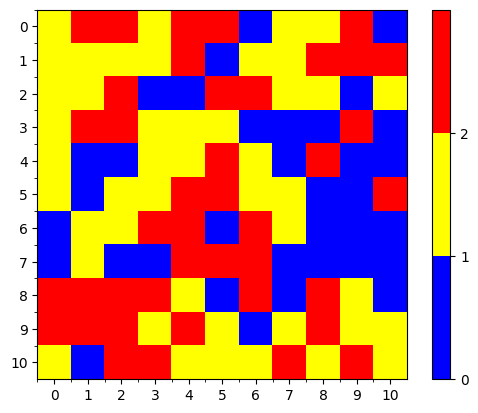

In [24]:
policy_GPI_flipped = policy_GPI[::-1, :]
cmap = colors.ListedColormap(['blue', 'yellow','red'])
values = [0, 1, 2,3]  
norm = colors.BoundaryNorm(values, cmap.N)

fig, ax = plt.subplots()

cax = ax.imshow(policy_GPI_flipped[1,:,:], cmap=cmap, norm=norm)

x_ticks = np.arange(0, policy_GPI_flipped.shape[2], 1)
y_ticks = np.arange(0, policy_GPI_flipped.shape[1], 1)

ax.set_xticks(x_ticks - 0.5, minor=True)  
ax.set_yticks(y_ticks - 0.5, minor=True)

ax.set_xticks(x_ticks)  
ax.set_yticks(y_ticks)

ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)
plt.colorbar(cax, ticks=[0, 1, 2]) 
plt.show()


[Text(0.5, 0, 'Temperature'), Text(0, 0.5, 'Humidity')]

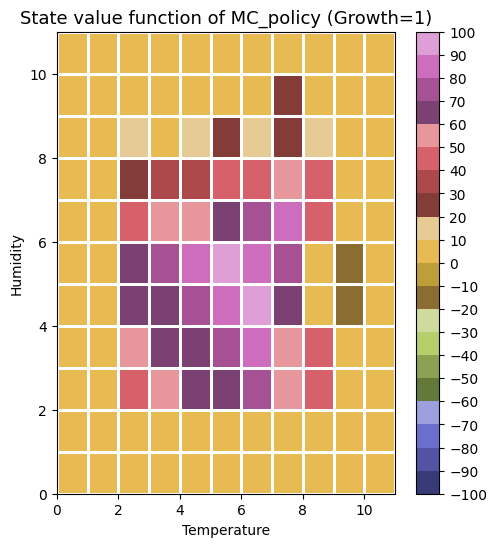

In [26]:
fig = plt.figure(figsize=(12,6))

ax = plt.subplot(1,2,1)
pc = ax.pcolormesh(V_policy[1,:,:] ,cmap='tab20b',vmin=-100, vmax=100, edgecolors='w')
cbar = fig.colorbar(pc)
cbar.set_ticks(np.arange(-100, 101, 10))
ax.set_title(f'State value function of MC_policy (Growth=1)', fontsize=13)
ax.set(xlabel='Temperature', ylabel='Humidity')


In [16]:
numbers,count=np.unique(V_policy[1,:,:],return_counts=True)

In [17]:
for number,count in zip(numbers,count):
    print(f'{number}: {count}')

-18.92031809979181: 1
-18.056859005112493: 1
0.0: 71
9.139788691965418: 1
13.66508215195304: 1
15.296093196787355: 1
17.88633897527874: 1
19.55873419004426: 1
25.41865828329001: 1
25.99353063443729: 1
29.4042494711642: 1
29.62684477100019: 1
33.41850785762252: 1
38.30087054597179: 1
41.315430819366675: 1
42.63110234795317: 1
43.38402164568581: 1
44.25054937980652: 1
44.77302338767799: 1
46.69141467204608: 1
47.70399783851345: 1
49.64397628916772: 1
50.46286170736709: 1
54.0826593016512: 1
54.447841965903514: 1
55.01065548378722: 1
55.50681161055227: 1
58.0878803930402: 1
59.32425984886848: 1
61.50589087849343: 1
61.88775572861548: 1
62.04430728664751: 1
65.7404293560533: 1
66.7506306875377: 1
67.63989571038555: 1
69.15383057804998: 1
69.59634080379335: 1
69.89785335782882: 1
72.97111541545777: 1
73.42922797134139: 1
75.72794696152651: 1
77.78557597209144: 1
77.9997181075371: 1
78.31720041574853: 1
82.3542605597111: 1
85.92753754448586: 1
86.88476084601879: 1
87.47472520165113: 1
89.833

In [31]:
st_list=[]
ac_list=[]
re_list=[]
counter=0
for _ in tqdm(range(pars['N_episodes'])):
 seq_state,seq_action,seq_reward=make_episode(policy_GPI,pars)
 counter+= 1 if seq_state[-1][0]==5 else 0
 st_list.append(seq_state)
 ac_list.append(seq_action)
 re_list.append(seq_reward)

100%|██████████| 10000/10000 [00:02<00:00, 3845.33it/s]


In [32]:
counter/pars['N_episodes']

0.9881

In [20]:
st_list=[]
ac_list=[]
re_list=[]
counter=0
for _ in tqdm(range(pars['N_episodes'])):
 seq_state,seq_action,seq_reward=make_episode(test_policy,pars)
 counter+= 1 if seq_state[-1][0]==5 else 0
 st_list.append(seq_state)
 ac_list.append(seq_action)
 re_list.append(seq_reward)

100%|██████████| 10000/10000 [00:03<00:00, 2542.99it/s]


In [29]:
counter/pars['N_episodes']

0.01

In [22]:
V_init=state_value_MC(st_list,ac_list,re_list,pars)

[Text(0.5, 0, 'Temperature'), Text(0, 0.5, 'Humidity')]

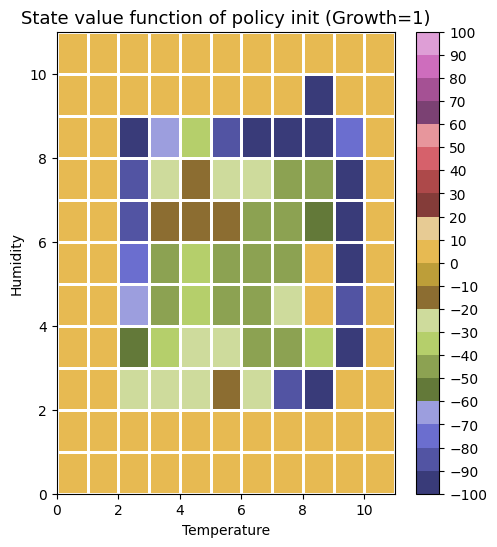

In [28]:
fig = plt.figure(figsize=(12,6))

ax = plt.subplot(1,2,1)
pc = ax.pcolormesh(V_init[1,:,:] ,cmap='tab20b',vmin=-100, vmax=100, edgecolors='w')
cbar = fig.colorbar(pc)
cbar.set_ticks(np.arange(-100, 101, 10))
ax.set_title(f'State value function of policy init (Growth=1)', fontsize=13)
ax.set(xlabel='Temperature', ylabel='Humidity')

In [33]:
from mpl_toolkits.mplot3d import Axes3D

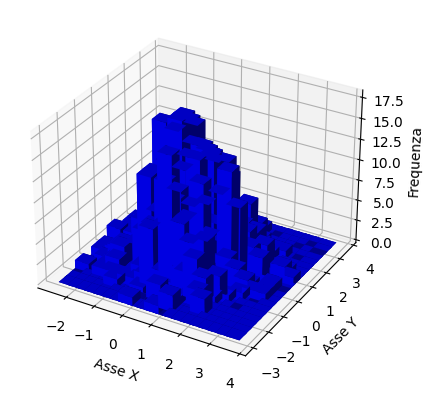

In [34]:
# Dati esemplificativi
a = np.random.randn(1000)
b = np.random.randn(1000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Calcolo dell'istogramma
hist, xedges, yedges = np.histogram2d(a, b, bins=20)

# Costruzione dei bordi del cubo per l'istogramma
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Dimensione dei cubi
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

# Etichette degli assi
ax.set_xlabel('Asse X')
ax.set_ylabel('Asse Y')
ax.set_zlabel('Frequenza')

plt.show()

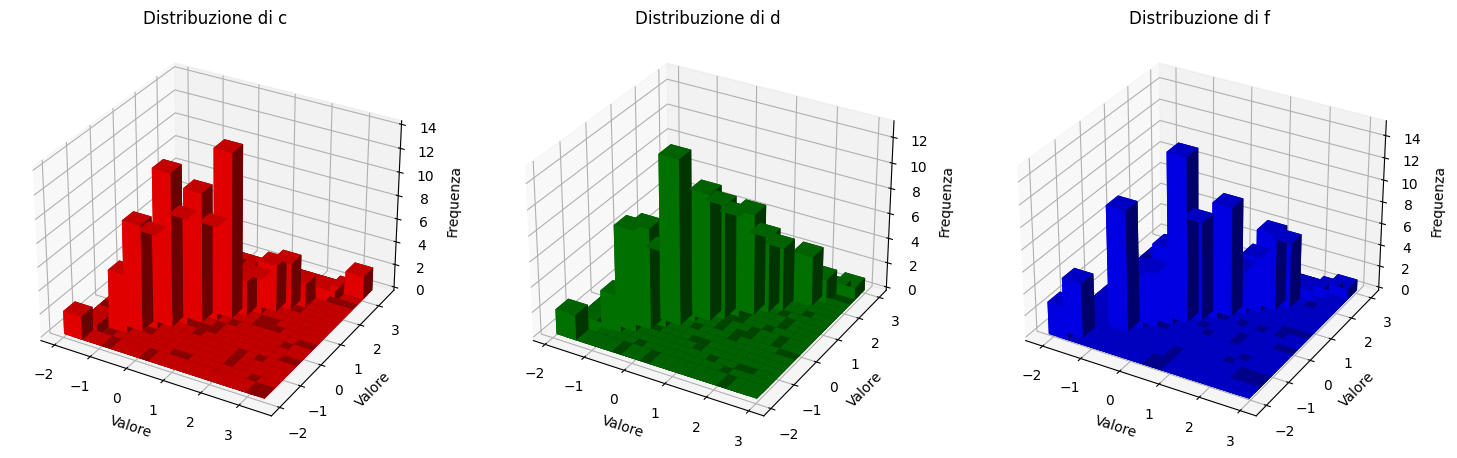

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generazione di dati esemplificativi
# Supponiamo che Q abbia forma (10, 10, 3) per semplicità, dove 10x10 sono le celle e 3 sono i valori per cella
Q = np.random.randn(10, 10, 3)

# Preparazione dei dati per l'istogramma
# Estraiamo ciascuno dei tre canali
data1 = Q[:, :, 0].flatten()  # Dati per la prima dimensione
data2 = Q[:, :, 1].flatten()  # Dati per la seconda dimensione
data3 = Q[:, :, 2].flatten()  # Dati per la terza dimensione

fig = plt.figure(figsize=(18, 6))

colors = ['red', 'green', 'blue']
titles = ['Distribuzione di c', 'Distribuzione di d', 'Distribuzione di f']

# Creazione di tre subplot, uno per ciascuna dimensione
for i, data in enumerate([data1, data2, data3]):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    hist, xedges, yedges = np.histogram2d(data, data, bins=20)

    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)

    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors[i], zsort='average')
    ax.set_title(titles[i])

    ax.set_xlabel('Valore')
    ax.set_ylabel('Valore')
    ax.set_zlabel('Frequenza')

    plt.show()
